# Data journalism: data visualisation – implementation of interactive graphs (web enabled), infographics.

This notebook explores how sentiment and metadata from social media posts can be used to predict user engagement (likes + retweets). We also correlate trending news topics to online activity. This will help jouranlists find tredning topics via Social media and see how they effect each other. 

This project delivers a real-time trend forecasting web app that analyzes world-related hashtags (e.g., #Fitness, #Climate Change, #Ukraine) on X and Reddit posts combined. It combines social media data with current news headlines (via the News API) Using NLP and machine learning, it extracts trending keywords, predicts post engagement (likes and retweets, upvotes), and forecasts topic popularity over 24–48 hours. The tool is deployed as an interactive Streamlit dashboard, offering visualizations like word clouds and trend curves. A Jupyter notebook documents the full data science workflow.


# Problem Statement: 

Trends on social media emerge and fade rapidly. Marketers, journalists, and researchers often struggle to anticipate these shifts. This project addresses that challenge by forecasting trend lifecycles, helping users optimize content timing and stay ahead of competitors.

## Objectives: 

1. To collect and preprocess real-time social media data from X (formerly Twitter) and Reddit, focusing on globally relevant hashtags (e.g., #ClimateChange, #Ukraine, #Fitness), along with current news headlines using the NewsAPI.
2. To perform sentiment analysis and keyword extraction on social media posts and news headlines using Natural Language Processing (NLP) techniques.
3. To develop predictive models that estimate user engagement, such as likes, retweets, and upvotes, based on post content, sentiment, and metadata (e.g., time posted, hashtag used).
4. To forecast the popularity of trending topics over a 24–48 hour period using time series analysis and trend modeling.
5. To analyze the correlation between news coverage and online social media activity, highlighting how news drives or reflects online trends.
6. To build and deploy an interactive Streamlit dashboard that:

#### Displays real-time trends,

#### Visualizes sentiment and keyword patterns (e.g., word clouds, trend curves),

#### Allows journalists and users to explore topic impact and forecast engagement.

7. To Document process

### Libraries Needed for notebook:



In [ ]:
!pip install pandas


In [4]:
from IPython.display import Image, display
import pandas as pd




### Libraries used in CODE not notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import praw
from datetime import datetime


streamlit
nltk
scikit-learn
pandas
matplotlib
numpy
seaborn
wordcloud
statsmodels
praw
textblob




ModuleNotFoundError: No module named 'pandas'

# Data Collection

## Data sources: 
For social media, we use the X api [1]. This allows you gather posts from X within defined parameters. This will be done using hashtags these usally represent trending topics [2]. The newsAPI [3] will be used to gather news articles based on the paramters from the X posts aswell as Reddit [4] posts, for example #Fitness retreived the posts will be the search paramter for the news posts. 

## *Please add other data sources here if used*


1. https://docs.x.com/x-api/introduction
2. https://www.shopify.com/nz/blog/twitter-hashtags
3. https://newsapi.org/
4. https://www.reddit.com/dev/api/

# Limitations: 

Within the bounds of the X api free acount you are entitled to 100 posts from X, with Reddit its a lot more but capped to 60 requests a minute. The combined dataset will give us roughly 600 bits of data to work with with the abilty to add more from reddit when needed. This may skew the data towards Reddit posts but by doing the sentiment scores it will average out over all the data. 

# Ethical data usage: 


### X: 
The X API can be used for a university project if it aligns with X’s License Agreement, prioritizing user privacy, transparency, and ethical data use while avoiding harmful applications like misinformation or unauthorized data scraping. Ensure compliance with platform policies and secure data handling, especially for public interest research, though access may require navigating paid tiers or specific approvals under regulations like the EU’s DSA. (https://developer.x.com/en/developer-terms/agreement-and-policy) 

### NewsAPI: 
The News API (https://newsapi.org/terms) can be ethically used for a university project by adhering to its terms, which require lawful data use, compliance with local regulations, and respecting intellectual property through proper source attribution. Ensure transparency, secure handling of the API key, and limit data use to non-commercial academic purposes within the free tier’s 500 requests/day, avoiding unauthorized redistribution of licensed content.


### Here is how the NewsAPI is used. This wont run on this notebook. 


In [3]:
@st.cache_data
def load_recent_news():
    try:
        newsapi = NewsApiClient(api_key="7af7d5e56edc4148aac908f2c9f86ac3")
        start_date = (datetime.now() - timedelta(days=14)).strftime('%Y-%m-%d')
        end_date = datetime.now().strftime('%Y-%m-%d')
        articles = newsapi.get_everything(q="*", from_param=start_date, to=end_date, language='en', page_size=100)
        news_df = pd.DataFrame([{
            "published_at": a['publishedAt'],
            "title": a['title'],
            "description": a['description']
        } for a in articles['articles']])
        news_df['published_at'] = pd.to_datetime(news_df['published_at'], utc=True)
        news_df['text'] = news_df['title'].fillna('') + " " + news_df['description'].fillna('')
        # Compute sentiment and topics
        news_df['sentiment'] = news_df['text'].apply(compute_sentiment)
        news_df['topic'] = extract_topics(news_df['text'].tolist())
        return news_df
    except Exception as e:
        st.warning(f"Failed to fetch news: {e}")
        return pd.DataFrame()

NameError: name 'NewsApiClient' is not defined

The parameters only allow 100 articles per request on the free version of the NewsAPI, and I set the date range to 2 weeks to maximize data coverage while staying within this limit. The @st.cache_data decorator ensures the data is cached to reduce redundant API calls during app usage.

# Reddit Data: 

Reddit uses a libary named 'praw', this is an API wrapper for reddit and is what receives the posts from Reddit. It does require an client ID, client_secret and user_agent which is given to you when you create an app through Reddit developer. 


https://praw.readthedocs.io/en/stable/

## Code Example: 

In [ ]:
reddit = praw.Reddit(
    client_id='v5b2CYNg37amXniM43bNmQ',
    client_secret='cqVeL5VR-vENbiLAjnfC-xoRn45qaQ',
    user_agent="MyRedditSentimentApp/0.1 by noahcrampton"
)

subreddit = reddit.subreddit("fitness")
posts = []

for post in subreddit.new(limit=1500):
    posts.append({
        "title": post.title,
        "score": post.score,
        "comments": post.num_comments,
        "created": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
        "url": post.url,
        "selftext": post.selftext,
        "subreddit": str(post.subreddit)
    })

df = pd.DataFrame(posts).drop_duplicates(subset="title")
df.sort_values(by="created", ascending=False, inplace=True)

print("Columns:", df.columns.tolist())
print(f"Latest post created: {df['created'].max()}")
print(f"Earliest post created: {df['created'].min()}")
print(f"Total unique posts: {len(df)}")

df.to_csv("data/reddit_fitness_recent_posts2.csv", index=False, date_format='%Y-%m-%d %H:%M:%S')
print("Saved to reddit_fitness_recent_posts2.csv")

# Data Handling and Merging


#### mergeData.py explanation: 

This section outlines how we processed and standardized the datasets from X (formerly Twitter) and Reddit to ensure compatibility for downstream analysis and prediction modeling.

### Issue: Inconsistent DateTime Formats

Initially, we encountered a critical issue with the created_at column across the two sources:

    1. Reddit and X data had different datetime formats and timezone awareness.

    2. This inconsistency caused problems during merging and limited our models to rely predominantly on X data, as it appeared first in the combined CSV.

To resolve this, we implemented uniform datetime parsing and timezone alignment for both datasets.

### Solution Implementation



X DATA 

In [1]:
nzst = pytz.timezone('Pacific/Auckland')

x_posts['created_at'] = pd.to_datetime(x_posts['created_at'], errors='coerce')

current_time = datetime.now(nzst).astimezone(pytz.UTC).strftime('%Y-%m-%d %H:%M:%S %Z')
invalid_x_dates = x_posts['created_at'].isna().sum()

if invalid_x_dates > 0:
    print(f"Filling {invalid_x_dates} invalid created_at in X posts with {current_time}")
    x_posts['created_at'] = x_posts['created_at'].fillna(pd.Timestamp(current_time, tz='UTC'))

x_posts['created_at'] = x_posts['created_at'].dt.tz_convert('UTC')

print(f"X posts date range: {x_posts['created_at'].min()} to {x_posts['created_at'].max()}")

x_posts_cleaned = x_posts[[
    "created_at", "text", "sentiment", "hour_of_day", "is_weekend", "engagement"
]]

NameError: name 'pd' is not defined

Reddit DATA

In [ ]:

def process_reddit(df):
    df['text'] = df['title'].fillna('') + ". " + df['selftext'].fillna('')
    df['created_at'] = pd.to_datetime(df['created'], errors='coerce', utc=True)
    
    current_time = datetime.now(nzst).astimezone(pytz.UTC).strftime('%Y-%m-%d %H:%M:%S %Z')
    invalid_dates = df['created_at'].isna().sum()
    
    if invalid_dates > 0:
        print(f"Filling {invalid_dates} invalid created_at in Reddit dataset with {current_time}")
        df['created_at'] = df['created_at'].fillna(pd.Timestamp(current_time, tz='UTC'))
    
    df['hour_of_day'] = df['created_at'].dt.hour
    df['is_weekend'] = df['created_at'].dt.dayofweek >= 5
    df['engagement'] = df['score'] + df['comments']
    df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    return df[["created_at", "text", "sentiment", "hour_of_day", "is_weekend", "engagement"]]


### Outcome: 
By ensuring consistent timezone-aware datetime formatting (all in UTC), we enabled seamless merging between the Reddit and X datasets on the created_at field. This correction significantly improved the integrity of our time-based analysis and allowed for fair inclusion of both sources in our predictive models.

# Combined Dataset

In the mergeData.py file, all the seperate datasets (X, reddit) are comboned to create one dataset that is used for the modelling. Below is a code snippet on how this was done.


In [ ]:
ombined_df = pd.concat([x_posts_cleaned, reddit_cleaned, reddit_two_cleaned, reddit_three_cleaned], ignore_index=True)
combined_df.dropna(subset=["text", "engagement"], inplace=True)
invalid_combined_dates = combined_df['created_at'].isna().sum()
if invalid_combined_dates > 0:
    current_time = datetime.now(nzst).astimezone(pytz.UTC).strftime('%Y-%m-%d %H:%M:%S %Z')
    print(f"Filling {invalid_combined_dates} invalid created_at in combined dataset with {current_time}")
    combined_df['created_at'] = combined_df['created_at'].fillna(pd.Timestamp(current_time, tz='UTC'))
print(f"Invalid created_at in combined dataset: {combined_df['created_at'].isna().sum()} out of {len(combined_df)} rows")
print(f"Combined dataset date range: {combined_df['created_at'].min()} to {combined_df['created_at'].max()}")

combined_df.to_csv("data/combined_social_data.csv", index=False)

# Data Cleaning & Preprocessing

Below is the code that cleans and organises the data, ensures there is simuilar colunm names for machine learning

In [ ]:


x_posts = pd.read_csv("data/x_posts_with_weather.csv")
reddit_posts = pd.read_csv("data/reddit_all_recent_posts.csv")

reddit_posts['text'] = reddit_posts['title'].fillna('') + ". " + reddit_posts['selftext'].fillna('')

reddit_posts['created_at'] = pd.to_datetime(reddit_posts['created'], errors='coerce')

reddit_posts['hour_of_day'] = reddit_posts['created_at'].dt.hour
reddit_posts['is_weekend'] = reddit_posts['created_at'].dt.dayofweek >= 5

reddit_posts['engagement'] = reddit_posts['score'] + reddit_posts['comments']

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

reddit_posts['sentiment'] = reddit_posts['text'].apply(get_sentiment)

reddit_renamed = reddit_posts.rename(columns={
    "created_at": "created_at",
    "text": "text",
    "engagement": "engagement",
    "sentiment": "sentiment",
    "hour_of_day": "hour_of_day",
    "is_weekend": "is_weekend"
})

reddit_cleaned = reddit_renamed[[
    "created_at", "text", "sentiment", "hour_of_day", "is_weekend", "engagement"
]]

x_posts['created_at'] = pd.to_datetime(x_posts['created_at'], errors='coerce')
x_posts_cleaned = x_posts[[
    "created_at", "text", "sentiment", "hour_of_day", "is_weekend", "engagement"
]]

combined_df = pd.concat([x_posts_cleaned, reddit_cleaned], ignore_index=True)

combined_df.dropna(subset=["text", "engagement"], inplace=True)

combined_df.to_csv("data/combined_social_data.csv", index=False)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)     

print(combined_df)

This preprocess_and_train() function is a machine learning pipeline for training a regression model to predict engagement (like likes, comments, etc.) based on various post features. Splits the dataset into training (80%) and testing (20%) sets using a fixed random seed for reproducibility. Chooses and initializes the machine learning model, user chooses the model via the Streamlit app:

RandomForestRegressor: ensemble method using many decision trees.

GradientBoostingRegressor: more sophisticated, sequentially improves weak learners.

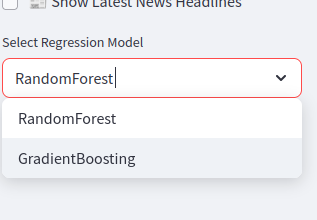

In [2]:

display(Image(filename='Images/screen1.png'))

In [ ]:
def preprocess_and_train(df, model_choice="RandomForest"):
    try:
        features = ['sentiment', 'text_length', 'hashtag_count', 'is_media', 'hour', 'is_weekend']
        X = df[features].fillna(0)
        y = df['engagement'].fillna(0)
        if len(X) < 10:
            raise ValueError("Not enough data for training (minimum 10 rows required).")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        if model_choice == "RandomForest":
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return {
            'r2_score': r2_score(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred
        }
    except Exception as e:
        st.error(f"Error in training model: {e}")
        return None

# Model Development

### Hybrid Prophet+XGBoost

This code snippet is part of the Streamlit app that implements a hybrid forecasting model combining Facebook Prophet and XGBoost to predict engagement over time (e.g., likes, shares, comments, etc.) Evaluates it with R² and RMSE. Plots:

    1. Time-series forecast from Prophet.

    2. Predicted vs. actual engagement using XGBoost.

   

In [10]:
def hybrid_prophet_xgb(df, forecast_periods=24):
    try:
        logger.info("Starting hybrid Prophet+XGBoost prediction")
        df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
        prophet_df = df[['created_at', 'engagement']].copy()
        prophet_df = prophet_df.rename(columns={'created_at': 'ds', 'engagement': 'y'})
        prophet_df = prophet_df.dropna()

        m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
        m.fit(prophet_df)

        future = m.make_future_dataframe(periods=forecast_periods, freq='H')
        forecast = m.predict(future)

        prophet_features = forecast[['ds', 'trend', 'weekly', 'daily']].copy()
        merged_df = df.merge(prophet_features, left_on='created_at', right_on='ds', how='left').drop(columns=['ds'])

        features = ['sentiment', 'hour', 'is_weekend', 'trend', 'weekly', 'daily']
        merged_df = merged_df.dropna(subset=features + ['engagement'])
        if len(merged_df) < 10:
            raise ValueError("Not enough data for XGBoost training.")

        X = merged_df[features]
        y = merged_df['engagement']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        xgb_model = XGBRegressor(n_estimators=150, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)

        future_df = forecast[forecast['ds'] > prophet_df['ds'].max()].copy()
        future_df['created_at'] = pd.to_datetime(future_df['ds'])
        future_df['hour'] = future_df['ds'].dt.hour
        future_df['is_weekend'] = (future_df['ds'].dt.dayofweek >= 5).astype(int)
        future_df['sentiment'] = 0.0  # Placeholder
        future_features = future_df[['sentiment', 'hour', 'is_weekend', 'trend', 'weekly', 'daily']]

        future_engagement_pred = xgb_model.predict(future_features)

        future_summary = {
            "average_engagement": float(np.mean(future_engagement_pred)),
            "max_engagement": float(np.max(future_engagement_pred)),
            "max_engagement_time": future_df['ds'].iloc[np.argmax(future_engagement_pred)].strftime('%Y-%m-%d %H:%M:%S'),
            "min_engagement": float(np.min(future_engagement_pred)),
            "min_engagement_time": future_df['ds'].iloc[np.argmin(future_engagement_pred)].strftime('%Y-%m-%d %H:%M:%S'),
            "trend": "increasing" if future_engagement_pred[-1] > future_engagement_pred[0] else "decreasing"
        }

        return {
            "prophet_forecast": forecast[['ds', 'yhat']],
            "xgb_model": xgb_model,
            "xgb_features": features,
            "r2_score": r2_score(y_test, y_pred),
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
            "X_test": X_test.assign(created_at=merged_df.loc[X_test.index, 'created_at']),
            "y_test": y_test,
            "y_pred": y_pred,
            "future_dates": future_df['ds'],
            "future_engagement_pred": future_engagement_pred,
            "future_summary": future_summary
        }
    except Exception as e:
        logger.error(f"Hybrid model error: {str(e)}", exc_info=True)
        return None

### Regression model

This code snippet is part of the Streamlit app that performs regression-based engagement prediction using a machine learning model selected by the user based on selected input via the app, #Fitness for example

In [ ]:
st.subheader("📈 Predict Engagement (Regression)")
try:
    with st.spinner("Training regression model..."):
        result = preprocess_and_train(filtered_df, model_choice)
    if result:
        st.success(f"✅ {model_choice} model trained successfully!")
        st.write(f"**R² Score**: {result['r2_score']:.2f}")
        st.write(f"**RMSE**: {result['rmse']:.2f}")
        chart_df = result['X_test'].copy()
        chart_df['Predicted Engagement'] = result['y_pred']
        chart_df['Actual Engagement'] = result['y_test'].values
        fig, ax = plt.subplots()
        ax.plot(chart_df.index, chart_df['Predicted Engagement'], label='Predicted', color='tab:purple')
        ax.plot(chart_df.index, chart_df['Actual Engagement'], label='Actual', color='tab:red')
        ax.set_title('Predicted vs Actual Engagement')
        ax.set_xlabel('Post Index')
        ax.set_ylabel('Engagement')
        ax.legend()
        st.pyplot(fig)

except Exception as e:
    st.error(f"Regression model error: {e}")

### NLP / LDA

The list nltk_resources contains names of NLTK datasets and models that need to be downloaded to use certain Natural Language Toolkit (NLTK) features.

In [4]:
nltk_resources = [
    'punkt', 'punkt_tab', 'stopwords', 'vader_lexicon',
    'averaged_perceptron_tagger', 'wordnet', 'omw-1.4'
]

The extract_topics function preprocesses a list of texts (removing stopwords, tokenizing, and filtering) and uses Latent Dirichlet Allocation (LDA) to assign one of three topic labels to each valid text. If there’s too little data or an error occurs, it returns a list of zeros matching the input size.

In [ ]:
def extract_topics(texts):
    stop_words = set(stopwords.words('english')) - {'run', 'pump'}
    processed_texts = [
        " ".join([
            word for word in word_tokenize(doc.lower())
            if (word.isalnum() or word.startswith('#') or word in ['🦵🏽', '💪🏽']) and word not in stop_words
        ]) for doc in texts if isinstance(doc, str) and doc.strip()
    ]
    processed_texts = [doc for doc in processed_texts if len(doc.strip().split()) > 1]
    if len(processed_texts) < 5:
        return [0] * len(texts)
    try:
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
        dtm = vectorizer.fit_transform(processed_texts)
        lda = LatentDirichletAllocation(n_components=3, random_state=42)
        lda.fit(dtm)
        topics = lda.transform(dtm).argmax(axis=1)
        padded_topics = [topics[i] if i < len(topics) else 0 for i in range(len(texts))]
        return padded_topics
    except Exception as e:
        logger.error(f"Topic modeling error: {e}")
        return [0] * len(texts)

### VADER Sentiment 


In [ ]:
try:
    sid = SentimentIntensityAnalyzer()
    test_score = sid.polarity_scores("I love this! It's amazing!")
    logger.debug(f"VADER test score: {test_score}")
    if test_score['compound'] == 0:
        st.warning("VADER sentiment analyzer may not be functioning correctly.")
except Exception as e:
    st.error(f"Failed to initialize VADER: {e}")
    st.stop()

In [ ]:
def compute_sentiment(text):
    try:
        text = str(text).strip()
        if not text or text.lower() in ['nan', 'none', '']:
            logger.debug(f"Empty or invalid text: {text}")
            return 0.0
        scores = sid.polarity_scores(text)
        compound_score = scores['compound']
        logger.debug(f"Text: {text[:50]}... Sentiment: {compound_score}")
        return compound_score
    except Exception as e:
        logger.error(f"Sentiment computation error for text '{text[:50]}...': {e}")
        return 0.0

This function ensures robust and fault-tolerant sentiment scoring using VADER, returning a compound score between -1 and 1, and defaulting to 0.0 for any invalid input or error.

# Predicting Headlines 

# Model Evaluation

# Forecasting & Trend Analysis

## Engagement & Sentiment Over Time


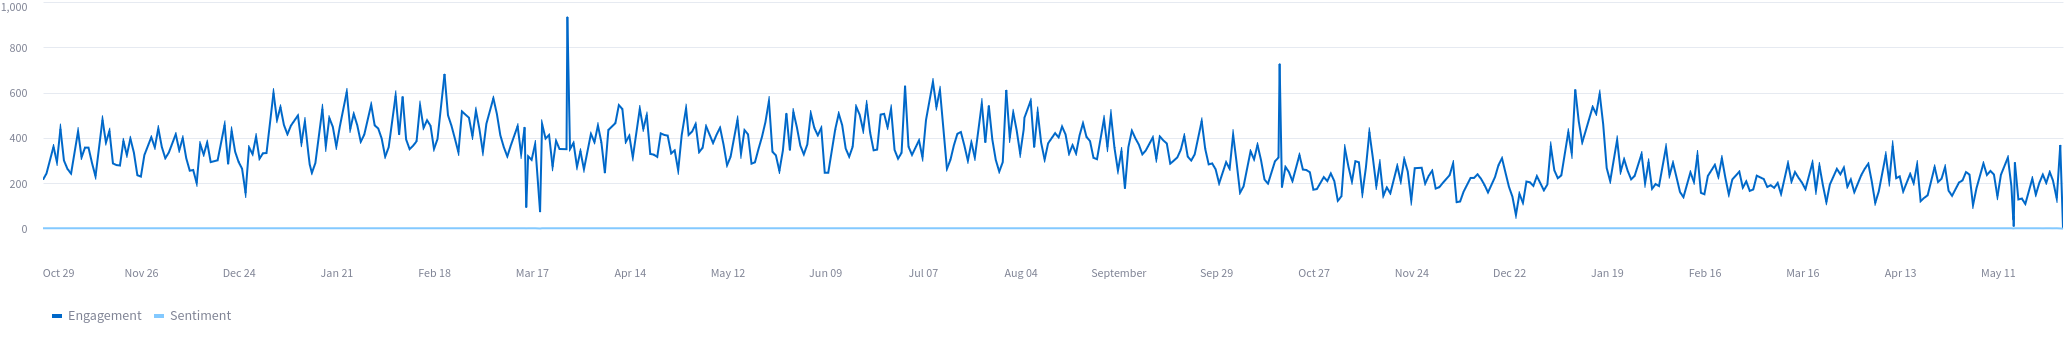

In [5]:
display(Image(filename='Images/screen2.png'))

The chart shows engagement and sentiment trends over a year, from late October 2024 to mid-May 2025. Engagement fluctuates between 0 and 1,000, with notable peaks around late November 2024, early January 2025, and mid-April 2025. Sentiment remains consistently low, hovering near 0 throughout the period, with minor variations. Overall, engagement shows periodic spikes, while sentiment remains stable and neutral.

## Time Series Regression with VAR


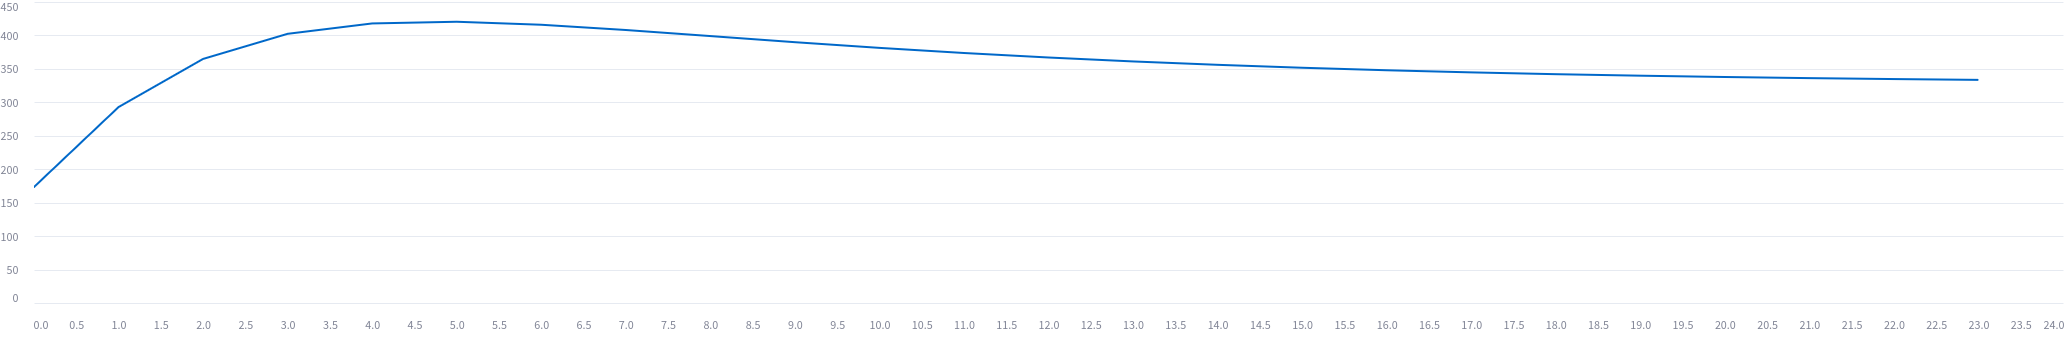

In [6]:
display(Image(filename='Images/screen3.png'))

The chart depicts a time series regression using a Vector Autoregression (VAR) model over a period of 24 time units. The metric starts at around 150, rises sharply to a peak of approximately 400 within the first 2 time units, and then gradually declines, stabilizing around 350 by the end of the period. This suggests an initial surge followed by a slow, consistent decrease, indicating the VAR model capturing both short-term dynamics and a longer-term downward trend.

A VAR Coefficents CSV was also made. Here are the findings

In [9]:

df = pd.read_csv('varco.csv', index_col=0)

print(df)


               engagement  sentiment     topic      hour  is_media
const          155.866537   0.024715  0.836124  4.596581 -0.047194
L1.engagement    0.567161  -0.000045  0.000110 -0.000101 -0.000015
L1.sentiment    33.585104   1.123817 -1.228811  1.729355 -0.032475
L1.topic        34.689561   0.249388 -0.352545 -2.515972 -0.043518
L1.hour         -4.826310  -0.013808  0.028490  0.362010  0.008863
L1.is_media    -93.369843  -0.168975  1.208633  4.767215  0.752934


Engagement is most positively influenced by past topic and sentiment, and most negatively influenced by past is_media. Past variables do have some predictive power, particularly L1.sentiment, L1.topic, and L1.is_media for modeling engagement.

# Predicting future engagement (Social media) 


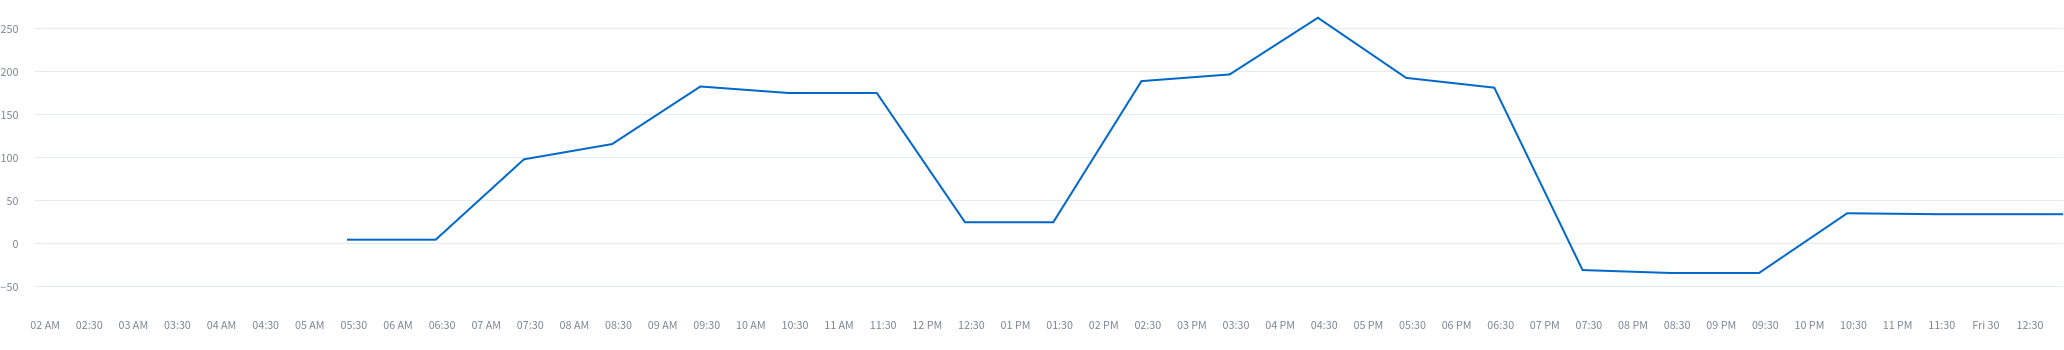

In [11]:
display(Image(filename='Images/screen4.png'))

### Summary of Future Engagement Predictions (Taken from Streamlit App)


    Average Predicted Engagement: 82.70

    Maximum Predicted Engagement: 261.99

    Peak Time: 2025-05-29 16:26:03

    Minimum Predicted Engagement: -34.84

    Low Point Time: 2025-05-29 20:26:03

    Trend Over the Period: Increasing


# Streamlit App Integration

# Insights & Conclusion